## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [20]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'as a synonym of type is deprecated')

from hparams import create_hparams
hparams = create_hparams()
hparams.batch_size = 4

In [15]:

import os

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
from scipy.io import wavfile
import numpy as np
import torch
import torch.nn as nn

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from convert_model import update_model

from train import prepare_dataloaders
from torch.utils.data import DataLoader

In [4]:
import denoiser

In [5]:
SAMPLE_RATE = 22050

PROJ_DIR = '/home/mcncm/class/6.867/proj'
FIGS_DIR = os.path.join(PROJ_DIR, 'writeup/figures')
AUDIO_DIR = os.path.join(PROJ_DIR, 'audio')

fontsize=14

def plot_data(filename, data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
    plt.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()

    
def plot_spectrogram(filename, spec, figsize=(16, 4), colorbar=False):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    im = axes.imshow(spec, aspect='auto', origin='bottom', 
                       interpolation='none')
    axes.set_xlabel('Frame', fontsize=fontsize)
    axes.set_ylabel('FFT bin', fontsize=fontsize)
    
    if colorbar:
        divider = make_axes_locatable(axes)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()

def save_audio(filename, audio):
    def center(data):
        """Rescale to [0, 1]"""
        data -= np.max(data) + np.min(data)
        data = data/np.max(data)
        return data
        
    path = os.path.join(AUDIO_DIR, filename)
    audio = center(audio.astype(np.float32))
    wavfile.write(path, SAMPLE_RATE, audio)

#### Setup hparams

In [6]:
hparams = create_hparams()
hparams.sampling_rate = SAMPLE_RATE

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [7]:
# checkpoint_path = "tacotron2_statedict.pt"
checkpoint_path = 'test-outdir/checkpoint_11000'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [9]:
waveglow_path = 'waveglow_256channels_ljs_v2.pt'
waveglow = update_model(torch.load(waveglow_path)['model']) 
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### An example utterance

In [10]:
train_loader, valset, collate_fn = prepare_dataloaders(hparams)

def val_text(i: int):
    return valset[i][0]

def val_spec(i: int):
    return valset[i][1]

In [11]:
val_loader = DataLoader(valset, sampler=None, num_workers=1,
                        shuffle=False, batch_size=4,
                        pin_memory=False, collate_fn=collate_fn)
x, y = model.parse_batch(next(iter(val_loader)))

In [12]:
y_pred = model(x, y[0])

In [ ]:
y_pred

In [13]:
def trim_spec(audio_data, threshold=-1e-7):
    r"""Find where data is last nonzero, then return up to that point
    """
    mins, _ = torch.min(audio_data, 0)
    return audio_data[:, (mins < threshold).nonzero().squeeze()]

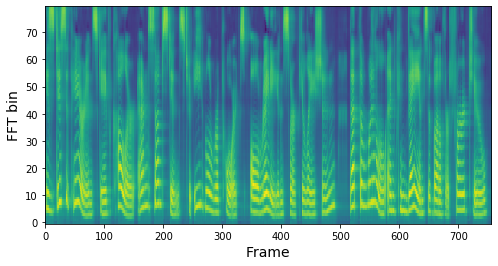

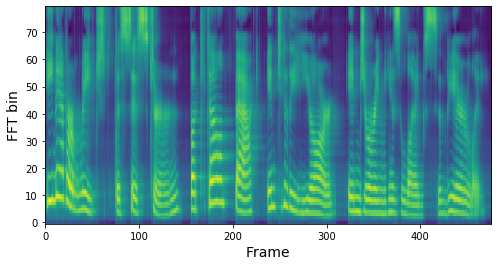

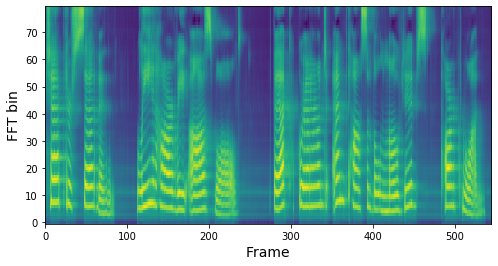

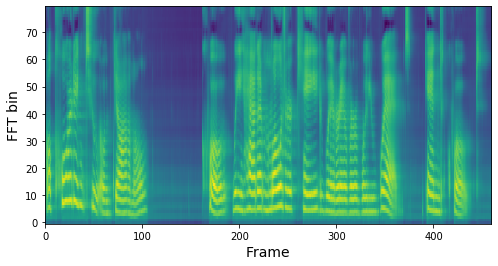

In [16]:
y_pred = model(x, y[0])

common_name = 'prosody_11k_steps'

# audio_data = denoiser(audio, strength=0.02).data.cpu().numpy()
specs = []
with torch.no_grad():
    for i in range(y_pred[0].shape[0]):
        spec = trim_spec(y_pred[0][i,...])
        specs.append(spec.cpu())
        audio_data = waveglow.infer(spec.unsqueeze(0), sigma=0.666)
 
        audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
        save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

        plot_spectrogram(common_name + "_{}".format(i) + '.png',
                         spec.float().data.cpu().numpy(),
                         figsize=(8, 4))


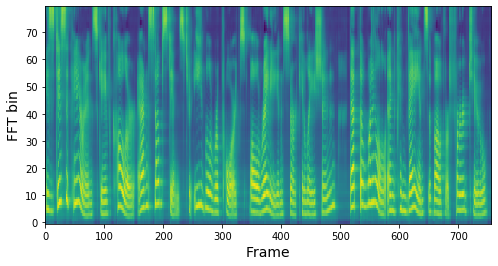

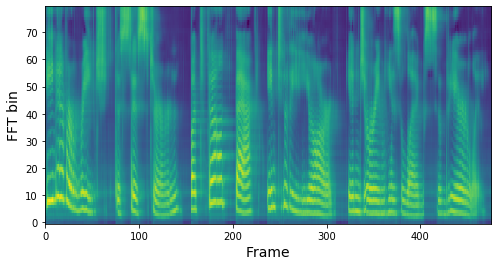

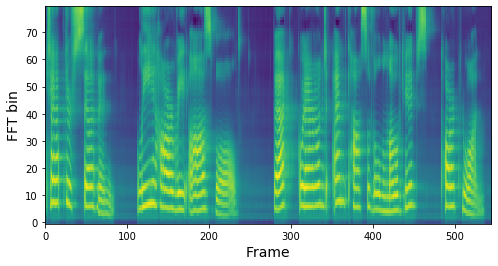

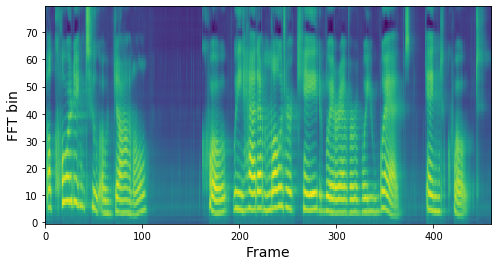

In [17]:
y_pred_transfer = model(x, y[0][(1,2,3,0),...])

common_name = 'prosody_11k_steps_transfer'

# audio_data = denoiser(audio, strength=0.02).data.cpu().numpy()
with torch.no_grad():
    for i in range(y_pred_transfer[0].shape[0]):
        spec_transfer = trim_spec(y_pred_transfer[0][i,...])
        audio_data = waveglow.infer(spec_transfer.unsqueeze(0), sigma=0.666)
 
        audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
        save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

        plot_spectrogram(common_name + "_{}".format(i) + '.png',
                         spec_transfer.float().data.cpu().numpy(),
                         figsize=(8, 4))

### Let's try perturbing the reference encodings.

In [ ]:


true_specs = [trim_spec(y[0][i,...]) for i in range(y[0].shape[0])]
embeddings = [model.reference_encoder(true_specs[i].unsqueeze(0)) for i in range(y[0].shape[0])]

In [ ]:
print(embeddings[0]) 

In [ ]:
checkpoint_path_old = 'test-outdir/checkpoint_10000'
model_old = load_model(hparams)
model_old.load_state_dict(torch.load(checkpoint_path_old)['state_dict'])
embeddings = [model_old.reference_epytorch ncoder(true_specs[i].unsqueeze(0)) for i in range(y[0].shape[0])]
print(embeddings[0])

### Little tools for hotswapping the encoder module

In [21]:
hparams.batch_size

4

In [22]:
class RandEncoder(nn.Module):
    def __init__(self, dimension, amplitude):
        super(RandEncoder, self).__init__()
        self.dimension = dimension
        self.amplitude = amplitude
    
    def forward(self, x):
        return self.amplitude * torch.rand(hparams.batch_size, self.dimension).cuda()

    
class ZeroEncoder(nn.Module):
    def __init__(self, dimension):
        super(ZeroEncoder, self).__init__()
        self.dimension = dimension
    
    def forward(self, x):
        return torch.zeros(hparams.batch_size, dimension).cuda()
    
class EncoderContext():
    r"""Swap in a new encoder module on the fly with a `with` statement.
    """
    def __init__(self, model, encoder):
        self.model = model
        self.encoder = encoder
    
    def __enter__(self):
        self.old_encoder = self.model.reference_encoder
        self.model._modules['reference_encoder'] = self.encoder
    
    def __exit__(self, type, value, traceback):
        print('exiting')
        self.model._modules['reference_encoder'] = self.old_encoder

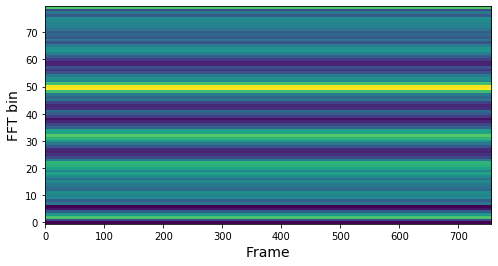

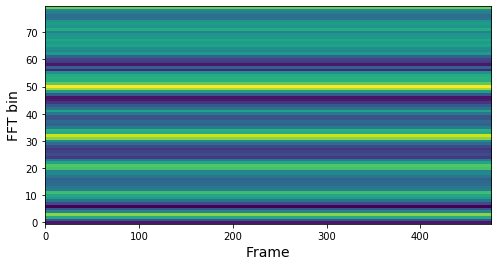

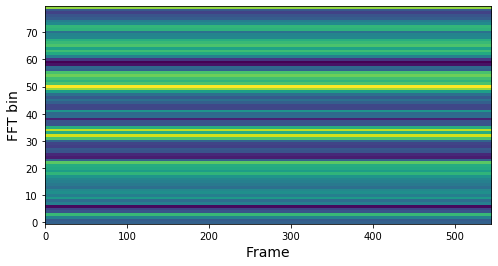

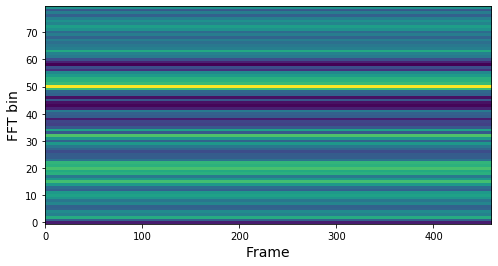

exiting


In [23]:
common_name = 'prosody_11k_steps_rand'

with EncoderContext(model, RandEncoder(128)):
    y_pred_rand = model(x, y[0])
    with torch.no_grad():
        for i in range(y_pred_rand[0].shape[0]):
            spec_transfer = trim_spec(y_pred_rand[0][i,...])
            audio_data = waveglow.infer(spec_transfer.unsqueeze(0), sigma=0.666)
 
            audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
            save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

            plot_spectrogram(common_name + "_{}".format(i) + '.png',
                             spec_transfer.float().data.cpu().numpy(),
                             figsize=(8, 4))

In [ ]:
model._modules['reference_encoder']

In [ ]:
with EncoderContext(model, RandEncoder(128)):
    with torch.no_grad():
        spec_transfer = trim_spec(y_pred_transfer[0][i,...])
        audio_data = waveglow.infer(spec_transfer.unsqueeze(0), sigma=0.666)
 
        audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
        save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

        plot_spectrogram(common_name + "_{}".format(i) + '.png',
                         spec_transfer.float().data.cpu().numpy(),
                         figsize=(8, 4))

#### Prepare text input

In [ ]:
text = "Institute has the finest professors."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

In [ ]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

In [ ]:
plot_data('triple_spectrogram.png',
          (mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [ ]:
common_name = 'institute_5k_steps'

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    data = audio[0].data.cpu().numpy()
    save_audio(common_name + '.wav', data)

plot_spectrogram(common_name + '.png',
                 mel_outputs_postnet.float().data.cpu().numpy()[0],
                 figsize=(8, 4))

#### Synthesize audio from spectrogram using WaveGlow

In [ ]:
mel_outputs_postnet

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
#audio[0].data.cpu().numpy()
torch.__version__

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 